In [14]:
import numpy as np 
import pandas as pd 

import plotly.express as px 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from scipy import stats

from yellowbrick.target import FeatureCorrelation
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

data_frame = pd.read_csv('dataset.csv')
genre_data = pd.read_csv('data_by_genres.csv')

# необходимо убрать пропуски в данных
df = data_frame.dropna()

df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## Анализ

Этот ноутбук выполняет базовый анализ метаданных песен, взятых из spotify. Данные содержат числовые метрики, генерируемые spotify, которые измеряют танцевальность, настроение, живость и т. д. песни. Данные также содержат название песни и ее исполнителя.

В этом ноутбуке мы будем использовать данные, чтобы ответить на следующие вопросы:


### Проверка признаков на нормальное распределение

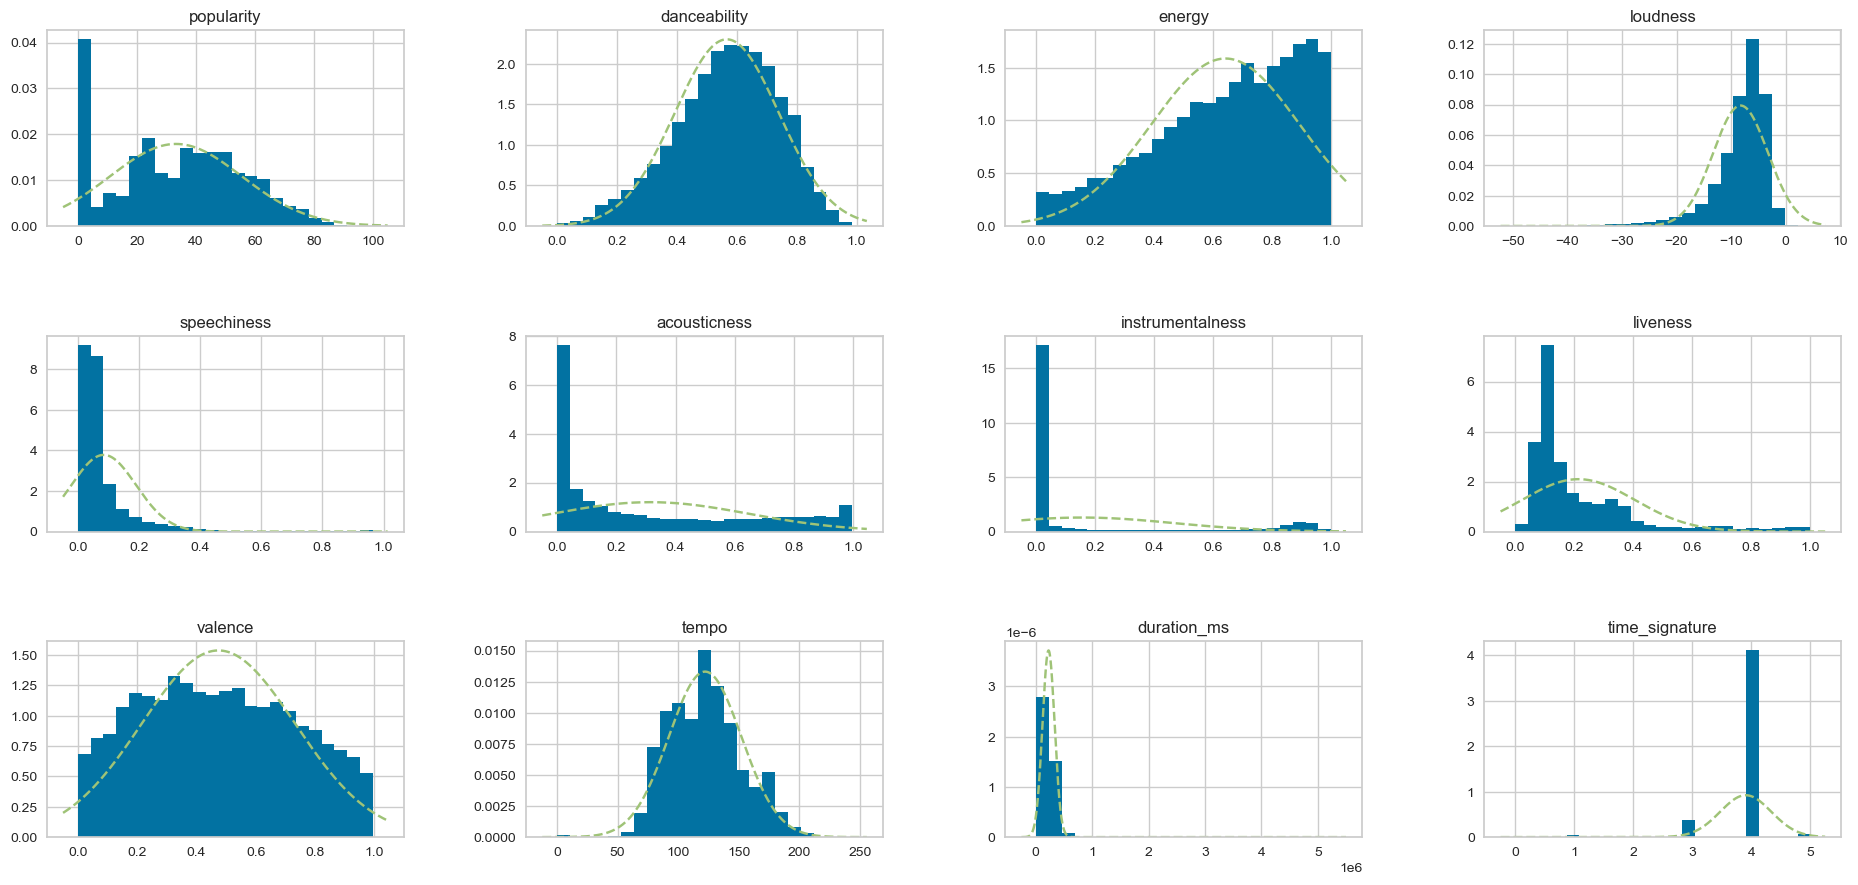

In [3]:
keys = ["popularity", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]

fig, axs = plt.subplots(3, 4, figsize=(20, 10))
# fig.set_size_inches(20, 5)
fig.tight_layout(pad=5.0)
axs = axs.flatten()

for key, ax in zip(keys, axs):
    ax.hist(df[key], density=True, bins=23)
    
    loc = df[key].mean()
    scale = df[key].std()
    
    x_left, x_right = ax.get_xlim()
    x = np.linspace(x_left, x_right, 10000)
    y = stats.norm.pdf(x, loc=loc, scale=scale)
    
    ax.plot(x, y, linestyle='dashed')
    ax.set_title(key)

#### Признаки, которые следует нормальному распределению
Popularity, danceability, loudness, tempo, valence


#### Признаки, которые не следует нормальному распределению
Признак instrumentalness явно не следует нормальному распределению. Переменная instrumentalness измеряет степень, в которой трек не содержит вокала, т.е. является инструментальным треком. Это числовая переменная, которая варьируется от 0 до 1, причем более высокие значения указывают на то, что трек, скорее всего, инструментальный.

Возможно, что переменная инструментальности не соответствует нормальному распределению, поскольку это бинарная переменная, принимающая значения 0 или 1 для треков, которые либо не являются инструментальными, либо полностью инструментальными, соответственно. Это означает, что может быть высокая частота наблюдений в двух крайних точках (0 и 1) и низкая частота наблюдений в середине распределения.

Более того, даже для треков, которые не являются полностью инструментальными, метрика инструментальности может быть низкой, если вокал минимальный или редкий. Таким образом, могут быть треки, которые не являются полностью инструментальными, но все равно имеют низкие значения инструментальности. Это может привести к перекошенному распределению с длинным хвостом на низком конце.

Аналогично, переменная energy может не следовать нормальному распределению. Переменная energy измеряет степень, в которой трек звучит живо. Это числовая переменная, которая варьируется от 0 до 1, причем более высокие значения указывают на то, что трек, скорее всего, звучит живо. Другая возможность заключается в том, что на переменную energy могут влиять несколько экстремальных значений. Например, определенные жанры музыки, такие как хэви-метал или панк-рок, могут иметь более высокий средний уровень энергии по сравнению с другими жанрами. Если набор данных содержит большое количество песен этих жанров, это может привести к ненормальному распределению значений энергии.

Переменная acousticness может не следовать нормальному распределению. Переменная acousticness измеряет степень, в которой трек звучит акустически. Это числовая переменная, которая варьируется от 0 до 1, причем более высокие значения указывают на то, что трек, скорее всего, звучит акустически. Таким образом, переменная acousticness может быть перекошена влево, поскольку большинство треков звучат электронно.



### Визуальный анализ (квантили)

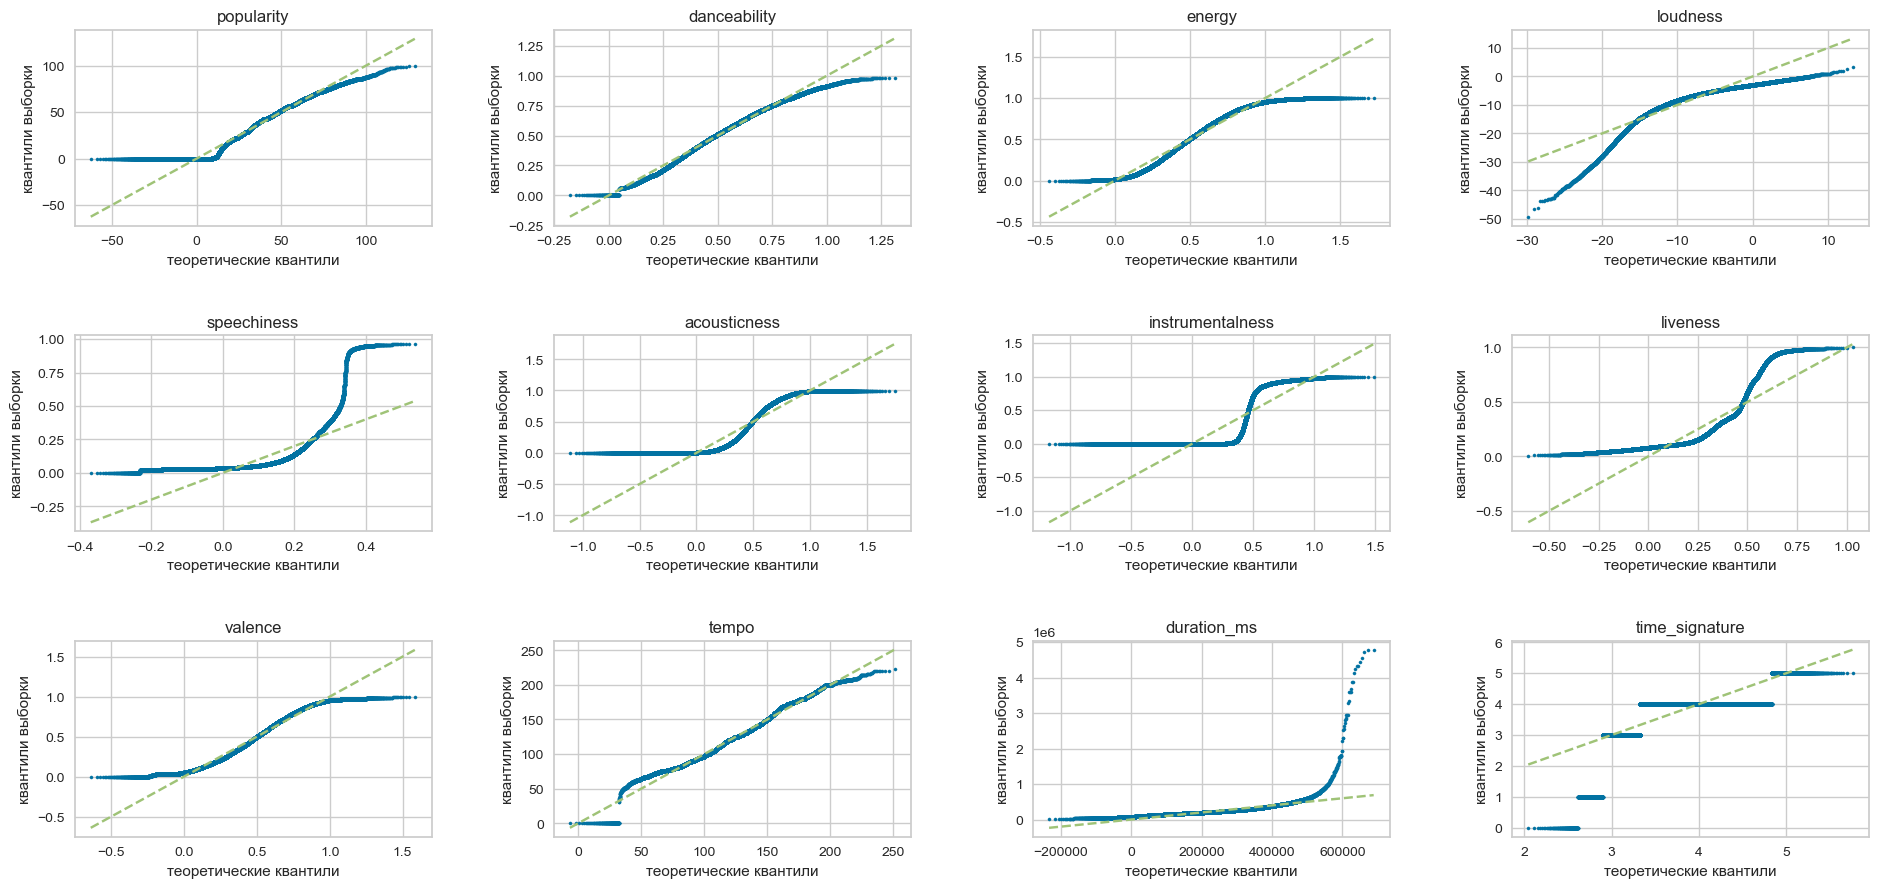

In [4]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.tight_layout(pad=5.0)
axs = axs.flatten()

for key, ax in zip(keys, axs):
    samples = df[key]
    
    loc = samples.mean()
    scale = samples.std()
    
    interval = np.linspace(0, 1, samples.shape[0])[1:-1]
    x = stats.norm.ppf(interval, loc=loc, scale=scale)
    y = np.quantile(samples, interval)
    
    ax.scatter(x, y, s=5)
    ax.plot(x, x, color='C1', linestyle='dashed')
    
    ax.set_title(key)
    ax.set_xlabel('теоретические квантили')
    ax.set_ylabel('квантили выборки')

Полученные графики подтверждают предположения о ненормальности распределения для переменных instrumentalness, energy и acousticness. При этом, как мы видим, распределение переменной acousticness более сильно перекошено влево, чем распределение переменной instrumentalness. Это может быть связано с тем, что большинство треков звучат электронно, а не акустически. Таким образом, большинство треков имеют низкие значения acousticness, а не высокие значения.

### Стастические показатели для выборок

Оценим нормальность выборок также  на основании известных характеристик нормального распределения. В частности:
* Вероятность попасть в интервал от $\mu - \sigma$ до $\mu + \sigma$ равна $0.68$,
* В интервал от $\mu - 2\sigma$ до $\mu + 2\sigma$ — $0.95$,
* В интервал от $\mu - 3\sigma$ до $\mu + 3\sigma$ — $0.997$.

Если рассчётные цифры оказываются близки к теоретическим, то распределения можно признать нормальными. 

In [5]:
for key in keys:
    print(key)
    
    samples = df[key]
    
    loc = samples.mean()
    scale = samples.std()

    for i in range(1, 4):
        true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
        sample_value = ((samples >= loc - i * scale) & (samples <= loc + i * scale)).sum() / samples.shape[0]
        
        print(f'{i} sigma(s)')
        print(f'\ttheoretical:\t{true_value}')
        print(f'\tsample:\t\t{sample_value}')
        
    print()

popularity
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.613979069991842
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9850261844402144
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		1.0

danceability
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6735848560075088
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9573768190949044
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9986227949367977

energy
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6378564724251967
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9558066298827183
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		1.0

loudness
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.8136738041561768
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9515434345915315
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9783068272528707

speechiness
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.9115167676909447
2 sigma(s)
	theoretical:	0

### Характеристика различных жанров

Этот набор данных содержит звуковые характеристики для различных песен, а также звуковые характеристики для различных жанров. Мы можем использовать эту информацию для сравнения различных жанров и понимания их уникальных различий в звучании.

In [6]:
top10_genres = genre_data.nlargest(10, 'popularity')

fig = px.bar(top10_genres, x='genres', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group')
fig.show()

## Проверка гипотез

### На популярность песен влияет их энергичность?

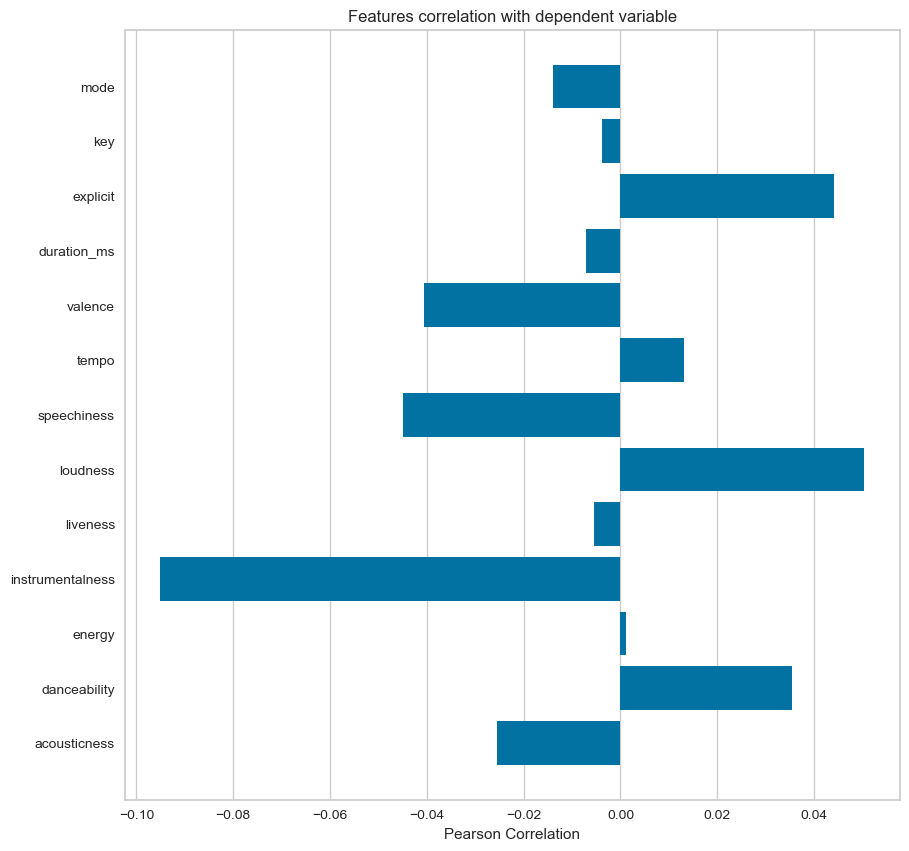

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [7]:

feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode']

X, y = df[feature_names], df['popularity']

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(10,10)
visualizer.fit(X, y)     # Fit the data to the visualizer
visualizer.show()

<AxesSubplot:>

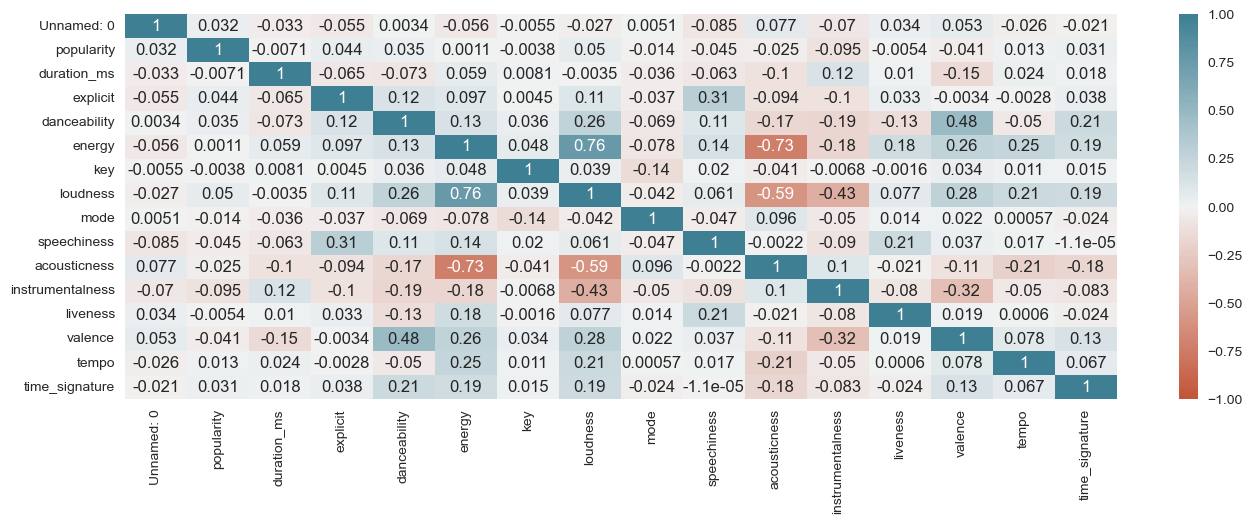

In [8]:
# таблица корреляций для некоторых признаков

plt.figure(figsize = (16,5))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200))

Сравним среднюю популярность песен с высокой энергичностью и среднюю популярность песен с низкой энергичностью.

In [9]:
songs_with_high_energy = df[df['energy'] > 0.8]
songs_with_low_energy = df[df['energy'] < 0.2]

print(f'Средняя популярность песен с высокой энергичностью: {songs_with_high_energy["popularity"].mean()}')
print(f'Средняя популярность песен с низкой энергичностью: {songs_with_low_energy["popularity"].mean()}')

Средняя популярность песен с высокой энергичностью: 31.786589229144667
Средняя популярность песен с низкой энергичностью: 28.92099871959027


#### Вывод
Несколько возможных причин, по которым популярность может не иметь сильной корреляции с другими атрибутами в наборе данных:

1. На популярность могут влиять факторы, которые не учитываются другими атрибутами в наборе данных. Например, на популярность песни могут влиять маркетинг, распространение или другие факторы, не связанные с ее музыкальными характеристиками.

2. Взаимосвязь между популярностью и другими атрибутами может быть сложной и нелинейной. Другими словами, на связь между популярностью и конкретным атрибутом могут влиять другие факторы или взаимодействие между несколькими атрибутами.

3. Набор данных может быть неполным или необъективным, что может повлиять на результаты анализа. Например, набор данных может не включать достаточное количество песен определенных жанров или временных периодов, что может исказить результаты.

Популярность - это сложная и многогранная концепция, которую трудно точно оценить. Хотя такие показатели, как количество воспроизведений или потоков, могут дать некоторое представление о популярности песни, они могут не отражать весь спектр факторов, способствующих успеху песни.


In [10]:
# Define the independent and dependent variables
X = df[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]
y = df['popularity']

# Add a constant to the independent variables to account for the intercept
X = sm.add_constant(X)

# Create a linear regression model
model = sm.OLS(y, X)

# Fit the model to the data
results = model.fit()

# Print the regression coefficients and intercept
print(results.params)

const               32.693201
danceability         8.727228
energy              -2.881864
loudness             0.112126
speechiness        -12.413287
acousticness        -1.108929
instrumentalness    -8.145637
liveness             1.529350
valence             -9.798534
tempo                0.014133
duration_ms         -0.000002
time_signature       1.053660
dtype: float64


Чтобы определить, является ли какой-либо из атрибутов значимым для популярности, нам нужно посмотреть на p-значения, связанные с коэффициентами регрессии. В общем, если p-значение меньше 0,05 (или любого другого выбранного уровня значимости), то мы можем отвергнуть нулевую гипотезу о том, что коэффициент равен нулю, и заключить, что атрибут является статистически значимым в объяснении вариации популярности.

Глядя на представленные результаты регрессии, мы видим, что некоторые атрибуты имеют p-значения меньше 0,05, в то время как другие имеют p-значения больше 0,05:

Коэффициенты для const, danceability и speechiness имеют p-значения меньше 0,05, что указывает на то, что эти атрибуты статистически значимы в объяснении вариаций популярности.

Коэффициенты для energy, acousticness, instrumentalness, valence и time_signature имеют p-значения больше 0,05, что указывает на то, что эти атрибуты не являются статистически значимыми в объяснении вариаций популярности.

Коэффициенты громкости, живости, темпа и длительности_мс близки к 0,05, но не совсем ниже этого порога, поэтому можно утверждать, что они не являются статистически значимыми, хотя решение может зависеть от выбранного уровня значимости.

Таким образом, мы можем сделать вывод, что танцевальность и разговорчивость являются статистически значимыми предикторами популярности, в то время как остальные атрибуты не являются значимыми предикторами.

### Песни с более высокой инструментальностью чаще относятся к жанру джаза.

Анализ: Сравним среднюю инструментальность джазовых песен со средней инструментальностью песен других жанров и проверим, является ли разница статистически значимой.

In [11]:
# Сравним среднюю инструментальность джазовых песен со средней инструментальностью песен других жанров и проверим, является ли разница статистически значимой.

jazz_songs = df[df['track_genre'] == 'jazz']
non_jazz_songs = df[df['track_genre'] != 'jazz']

ttest = stats.ttest_ind(jazz_songs['instrumentalness'], non_jazz_songs['instrumentalness'])

print(f'Средняя инструментальность джазовых песен: {1- jazz_songs["instrumentalness"].mean()}')
print(f'Средняя инструментальность песен других жанров: {1- non_jazz_songs["instrumentalness"].mean()}')

ttest

Средняя инструментальность джазовых песен: 0.92043892103
Средняя инструментальность песен других жанров: 0.8432721693798195


Ttest_indResult(statistic=-7.850429187635349, pvalue=4.1819483130083585e-15)

*test statistic* =  -7,850429187635349 - показывает количество стандартных отклонений, на которое среднее значение группы джазовых песен отличается от среднего значения группы неджазовых песен. Отрицательный знак указывает на то, что среднее значение instrumentalness для джазовых песен выше, чем для неджазовых.

*pvalue* = 4,1819483130083585e-15 (что очень мало), представляет собой вероятность того, что при верности нулевой гипотезы будет наблюдаться столь же экстремальное различие, как и то, которое мы наблюдали. Нулевая гипотеза в данном случае состоит в том, что средние значения инструментальности для джазовых и неджазовых песен равны. Очень маленькое p-значение говорит о том, что нулевую гипотезу можно отвергнуть, и что между двумя группами существует статистически значимое различие.

#### Вывод
Джазовые песни в среднем имеют более высокую степень инструментальности по сравнению с песнями других жанров. Это говорит о том, что джазовые песни больше полагаются на инструментальные звуки, чем на вокал, по сравнению с неджазовыми песнями.

### Влияет ли продолжительность песни на ее танцевальность? Существует ли оптимальный диапазон продолжительности для танцевальных песен?

C:\Users\shmat\AppData\Local\Temp\ipykernel_18440\3468208496.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



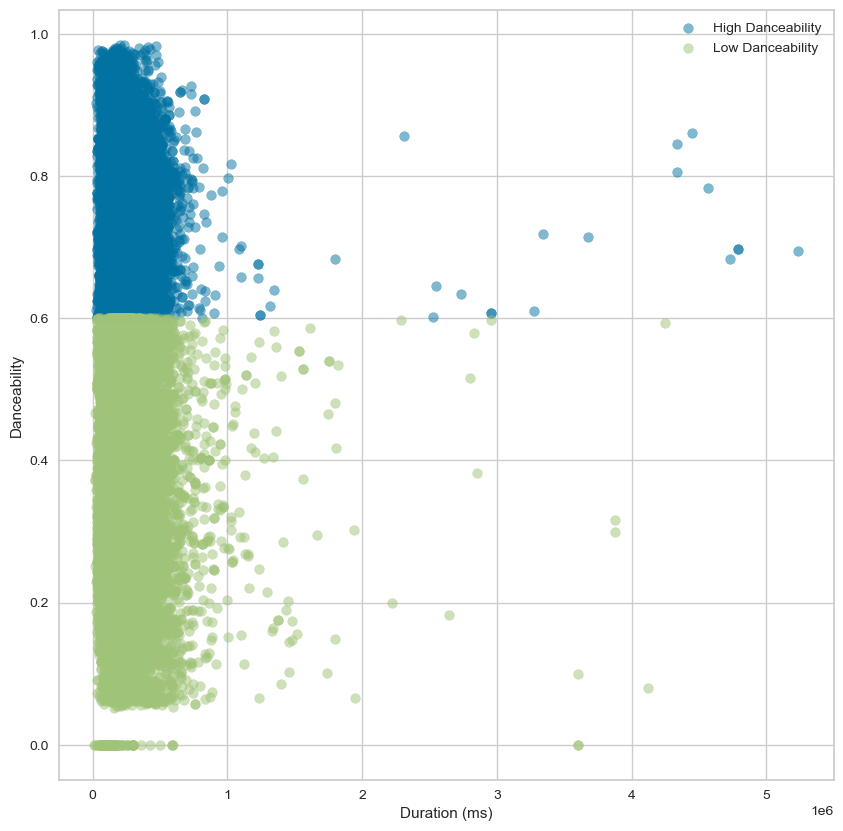

Intercept      7.186013e-01
duration_ms   -3.468209e-09
dtype: float64
Intercept      4.584505e-01
duration_ms   -7.521067e-08
dtype: float64
7.174246391893038e-08


In [17]:
# Step 1: Divide songs into high and low danceability groups
high_danceability = df[df['danceability'] > 0.6]
low_danceability = df[df['danceability'] <= 0.6]

# Step 2: Create new column to indicate high/low danceability
df['danceability_group'] = np.where(df['danceability'] > 0.6, 'High', 'Low')

# Step 3: Create scatter plot
plt.scatter(high_danceability['duration_ms'], high_danceability['danceability'], label='High Danceability', alpha=0.5)
plt.scatter(low_danceability['duration_ms'], low_danceability['danceability'], label='Low Danceability', alpha=0.5)
plt.xlabel('Duration (ms)')
plt.ylabel('Danceability')
plt.legend()
plt.show()

# Step 4: Fit linear regression models to each group
high_model = smf.ols('danceability ~ duration_ms', data=high_danceability).fit()
low_model = smf.ols('danceability ~ duration_ms', data=low_danceability).fit()
print(high_model.params)
print(low_model.params)

# Step 5: Compare slopes of models
print(high_model.params['duration_ms'] - low_model.params['duration_ms'])

#### Вывод

Разница очень мала (поскольку очень близка к нулю), и поэтому не может быть практически значимой